In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy import stats
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/asdfghj/Screenshot 2020-06-22 at 16.09.48.png
/kaggle/input/jhgfds/sample_submit.csv
/kaggle/input/jhgfds/test.csv
/kaggle/input/jhgfds/train.csv


Thanks to organizers for this really cool competition and very unusual for data science. Especially the second part of competition was really nice and I learned something new from linear programming trying to make optimization as efficient as possible taking into account the bias from predicted target.

Prohack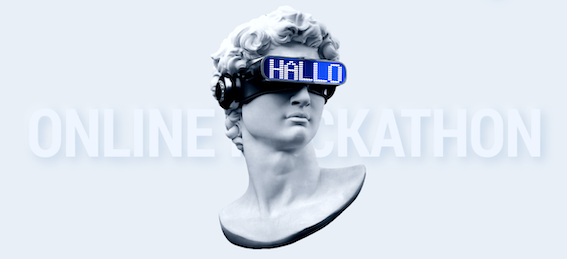

SciPy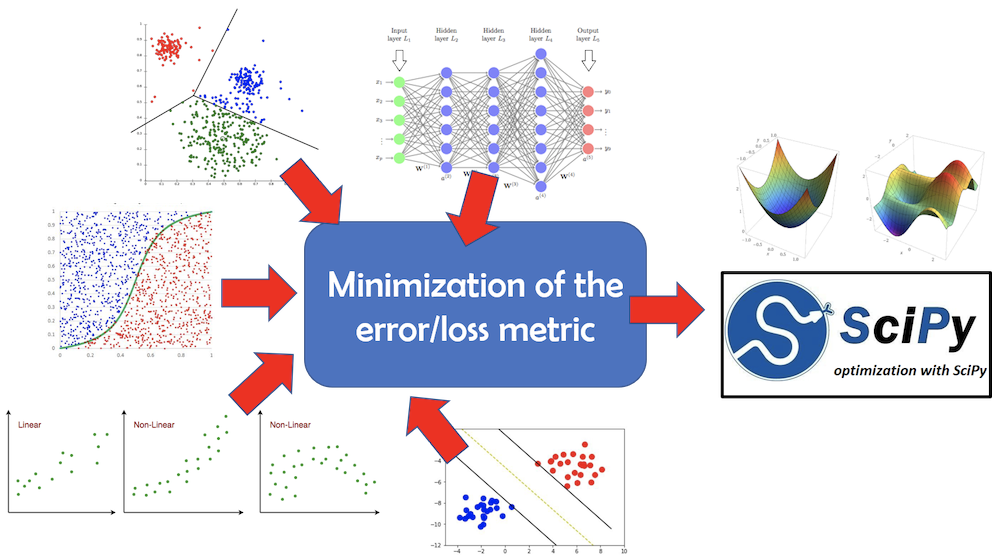

In [105]:
train = pd.read_csv('/kaggle/input/jhgfds/train.csv')
test = pd.read_csv('/kaggle/input/jhgfds/test.csv')
sample = pd.read_csv('/kaggle/input/jhgfds/sample_submit.csv')
df = pd.concat([train ,test], ignore_index = True)
SEED = 42

In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 80 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            3865 non-null   int64  
 1   galaxy                                                                                   3865 non-null   object 
 2   existence expectancy index                                                               3864 non-null   float64
 3   existence expectancy at birth                                                            3864 non-null   float64
 4   Gross income per capita                                                                  3837 non-null   float64
 5   Income Index                                                  

In [107]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 79 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   galactic year                                                                            890 non-null    int64  
 1   galaxy                                                                                   890 non-null    object 
 2   existence expectancy index                                                               885 non-null    float64
 3   existence expectancy at birth                                                            885 non-null    float64
 4   Gross income per capita                                                                  885 non-null    float64
 5   Income Index                                                    

In [108]:
for col in df.iloc[:,2:].columns.values:
    mean = df[col].mean()
    df[col] = df[col].fillna(mean)

In [109]:
cor = pd.DataFrame(train.corr()['y'].abs()).sort_values('y')

a = cor[cor['y'] > 0.1]

a

,y
Private galaxy capital flows (% of GGP),0.130659
"Outer Galaxies direct investment, net inflows (% of GGP)",0.130775
Youth unemployment rate (female to male ratio),0.147256
Adjusted net savings,0.164614
"Remittances, inflows (% of GGP)",0.182792
...,...
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),0.679981
"Intergalactic Development Index (IDI), male, Rank",0.680577
"Intergalactic Development Index (IDI), Rank",0.681592
Gender Inequality Index (GII),0.722279


In [110]:
# create some lags
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    df['lag_' + str(i)] = df.groupby(['galaxy'])['y'].shift(i)

In [111]:
train_new = df[:train.shape[0]]
test_new = df[train.shape[0]:]

In [112]:
print('New train shape: {}'.format(train_new.shape))
print('New test shape: {}'.format(test_new.shape))

New train shape: (3865, 90)
New test shape: (890, 90)


In [113]:
le = LabelEncoder()
train_new['galaxy'] = le.fit_transform(train_new.galaxy)
test_new['galaxy'] = le.transform(test_new.galaxy)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [114]:
X = train_new.drop(['y'], axis = 1)
y = train_new.y
X_test = test_new.drop(['y'], axis = 1)

<h3> LGBM

In [115]:
import re
X = X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [116]:
params_lgb = {
   
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'seed': SEED,
    'learning_rate': 0.1,
    'feature_fraction': 0.95,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'verbose': 3,
    'max_depth': 6,
    'num_leaves': 20
    }

def RMSE_error(y, y_pr):
    return np.sqrt(mean_squared_error(y, y_pr))
import lightgbm as lgb
scores = []
folds = KFold(n_splits = 5)

predictions = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
   
    print("Fold {}".format(fold_))


    trn_data = lgb.Dataset(X.iloc[trn_idx], label = y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label = y.iloc[val_idx])

    num_round = 1000000
    
    lgbm = lgb.train(params_lgb, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval = 1000, early_stopping_rounds = 100)
    predictions_val = lgbm.predict(X.iloc[val_idx], num_iteration = lgbm.best_iteration)
    
    score = RMSE_error(predictions_val, y.iloc[val_idx])
    scores.append(score)
    
    print("CV score: {:<8.5f}".format(RMSE_error(predictions_val, y.iloc[val_idx])))

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = lgbm.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    predictions += lgbm.predict(X_test, num_iteration = lgbm.best_iteration) / folds.n_splits
    
print('CV mean: {:.6f}, CV std: {:.6f}'.format(np.mean(scores), np.std(scores)))

Fold 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's rmse: 0.0157495	valid_1's rmse: 0.0306752
CV score: 0.03068 
Fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	training's rmse: 0.00898552	valid_1's rmse: 0.00331369
CV score: 0.00331 
Fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's rmse: 0.00728999	valid_1's rmse: 0.00418475
CV score: 0.00418 
Fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	training's rmse: 0.00489439	valid_1's rmse: 0.00471616
CV score: 0.00472 
Fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[635]	training's rmse: 0.000813855	valid_1's rmse: 0.026991
CV score: 0.02699 
CV mean: 0.013976, CV std: 0.012195


Text(0.5, 1.0, 'Features importance (averaged/folds)')

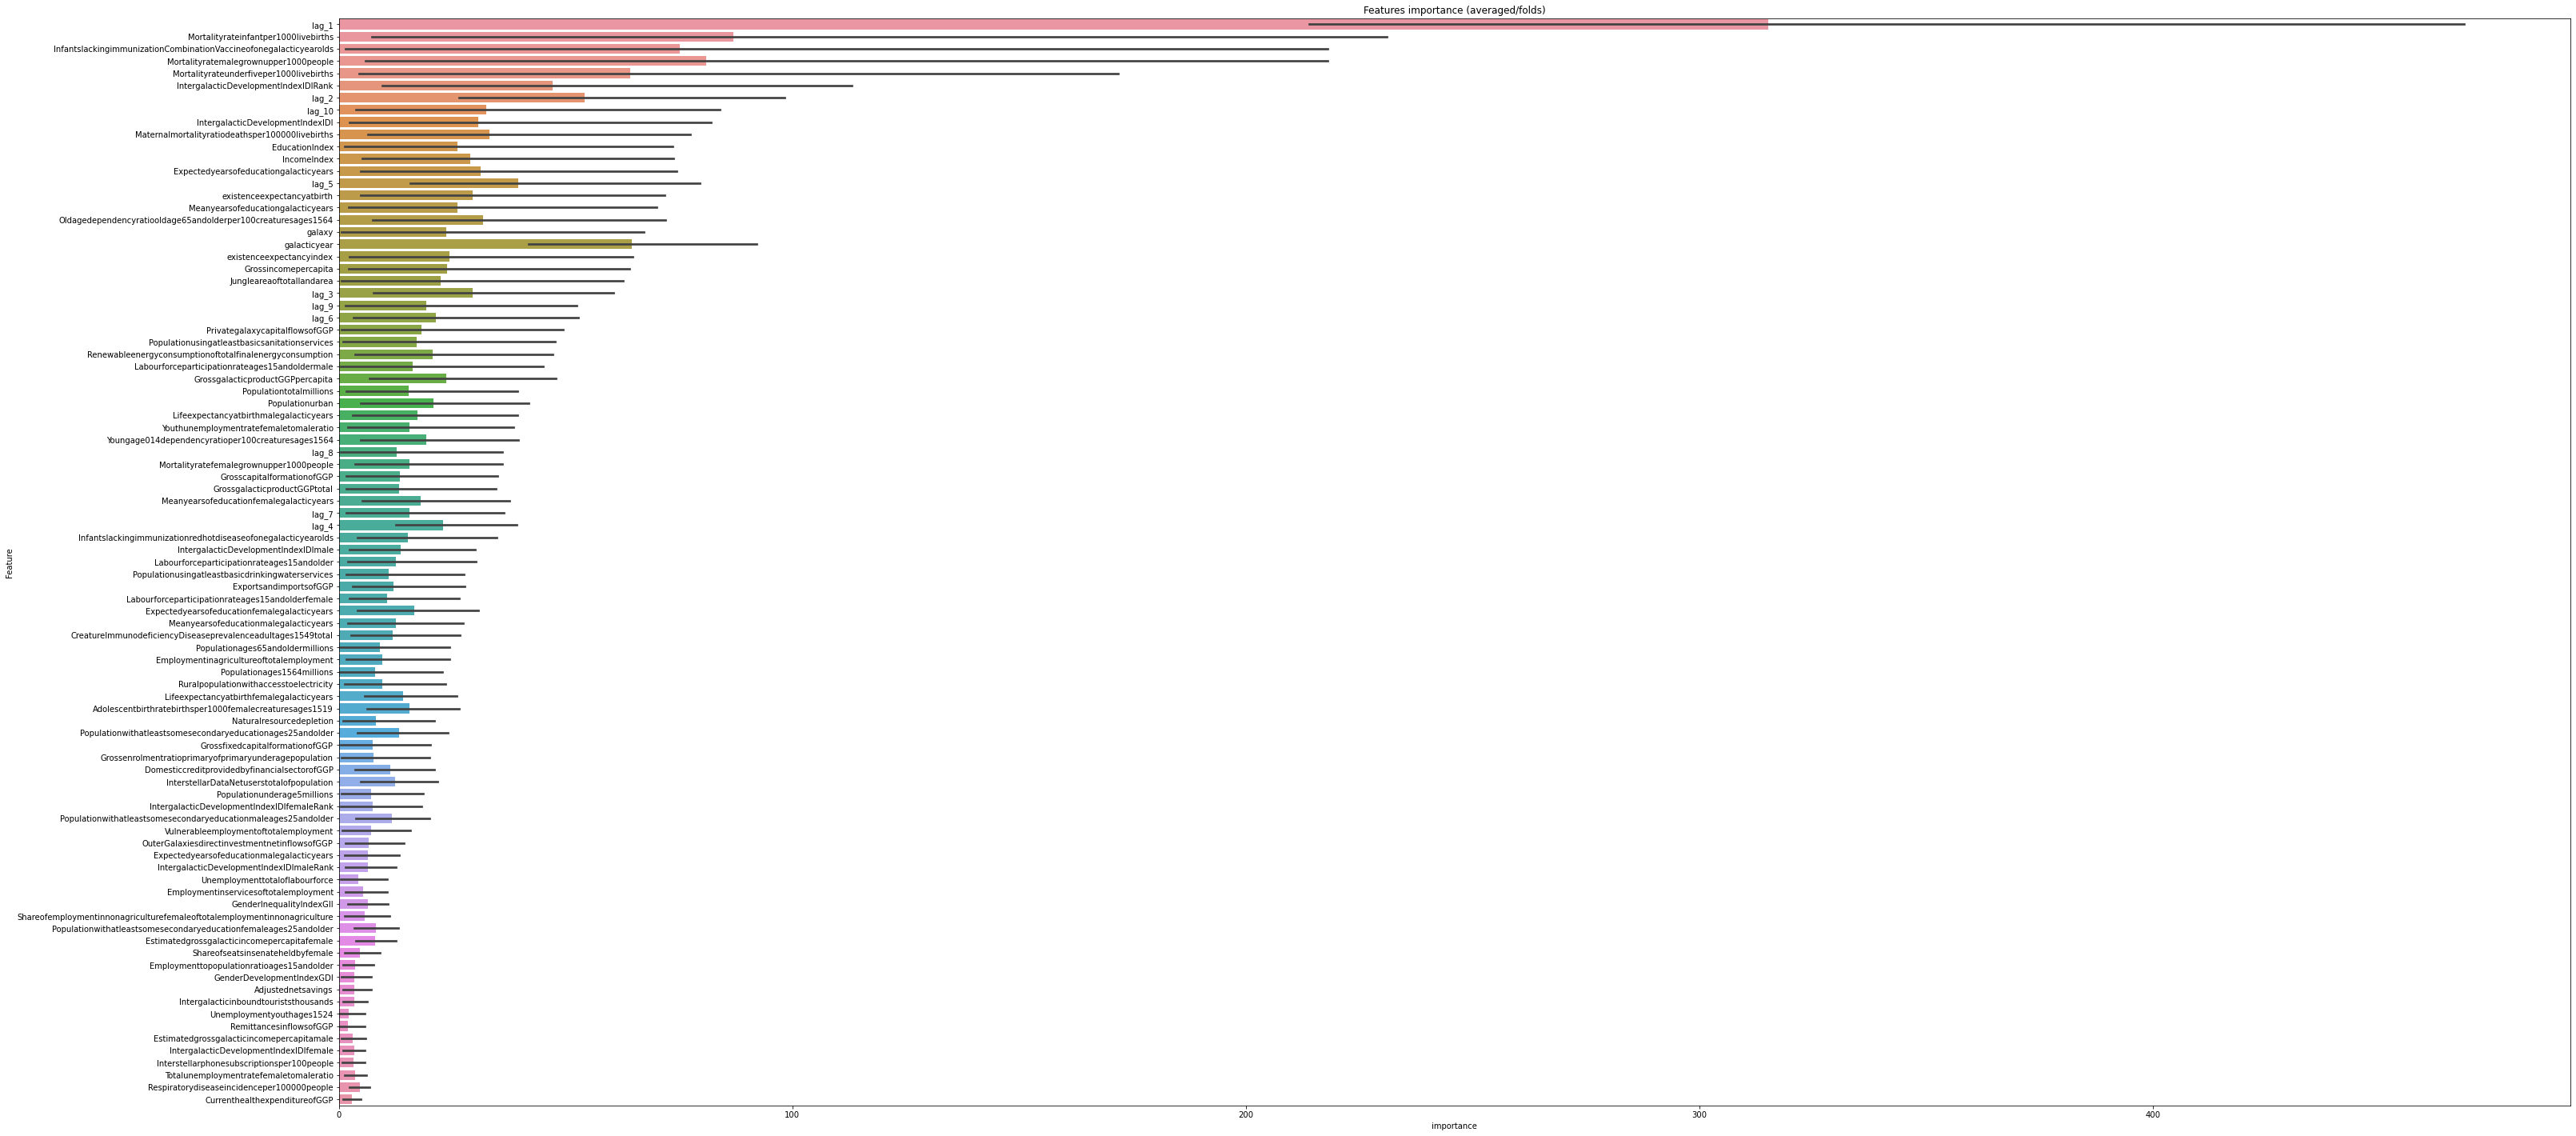

In [117]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by = "importance", ascending = False).index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize = (50, 25))
sns.barplot(x = "importance", y = "Feature", data = best_features.sort_values(by = "importance", ascending = False))
plt.title('Features importance (averaged/folds)')

In [118]:
important_cols = ['galacticyear', 'galaxy', 'lag_1']
X = X[important_cols]
X_test = X_test[important_cols]
X['y'] = train.y
X = X[~X['galaxy'].isin(['Triangulum Galaxy (M33)', 'Tucana Dwarf', 'Andromeda XXII[57]', 'NGC 5253', 'Andromeda XXIV', 'Andromeda XVIII[60]', 'Andromeda XII', 'Andromeda XIX[60]', 'Hercules Dwarf'])]
X['galaxy'] = X['galaxy'].astype('object')
target_mean = dict(X.groupby(['galaxy'])['y'].agg('mean'))
target_median = dict(X.groupby(['galaxy'])['y'].agg('median'))
target_max = dict(X.groupby(['galaxy'])['y'].agg('max'))
target_min = dict(X.groupby(['galaxy'])['y'].agg('min'))
target_change = dict(X.groupby(['galaxy'])['y'].agg('max') - X.groupby(['galaxy'])['y'].agg('min'))
target_percentile_1 = dict(X.groupby(['galaxy'])['y'].apply(lambda y: np.percentile(y, 95)))
target_percentile_2 = dict(X.groupby(['galaxy'])['y'].apply(lambda y: np.percentile(y, 99)))
target_std = dict(X.groupby(['galaxy'])['y'].agg('std'))
target_var = dict(X.groupby(['galaxy'])['y'].agg('var'))
target_end = dict(X.groupby(['galaxy'])['y'].agg('last'))

In [119]:
for i in [X, X_test]:
    i['mean'] = i['galaxy'].map(target_mean)
    i['median'] = i['galaxy'].map(target_median)
    i['max'] = i['galaxy'].map(target_max).values
    i['min'] = i['galaxy'].map(target_min).values
    i['percentile_1'] = i['galaxy'].map(target_percentile_1)
    i['percentile_2'] = i['galaxy'].map(target_percentile_2)
    i['std'] = i['galaxy'].map(target_std)
    i['var'] = i['galaxy'].map(target_var)
    i['end'] = i['galaxy'].map(target_end)
    i['change'] = i['galaxy'].map(target_change)

y = X.y    
X = X.drop(['galaxy', 'lag_1', 'y'], axis = 1)
X_test = X_test.drop(['galaxy', 'lag_1'], axis = 1)

<h3> Find ensemble weights for 3 model (Catboost, lightgbm, xgboost)

In [120]:
# split dataset for train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [121]:
# catboost predictions
catboost_parameters = {
          'eval_metric' : "RMSE",
          'learning_rate' : 0.1,
          'iterations' : 5000,
          'l2_leaf_reg' : 5,
          'random_seed' : SEED,
          'depth' : 74
          'early_stopping_rounds' : 100,
          'use_best_model' : True
         }
cb = CatBoostRegressor(**catboost_parameters)
cb.fit(X_train, y_train, eval_set = (X_valid, y_valid))
pred_catboost = cb.predict(X_valid)

0:	learn: 0.0586861	test: 0.0534639	best: 0.0534639 (0)	total: 5.64ms	remaining: 28.2s
1:	learn: 0.0537809	test: 0.0488758	best: 0.0488758 (1)	total: 9.52ms	remaining: 23.8s
2:	learn: 0.0494601	test: 0.0448089	best: 0.0448089 (2)	total: 13.2ms	remaining: 21.9s
3:	learn: 0.0454569	test: 0.0410090	best: 0.0410090 (3)	total: 16.8ms	remaining: 21s
4:	learn: 0.0418324	test: 0.0374725	best: 0.0374725 (4)	total: 20.4ms	remaining: 20.4s
5:	learn: 0.0386012	test: 0.0344445	best: 0.0344445 (5)	total: 24ms	remaining: 20s
6:	learn: 0.0355871	test: 0.0316145	best: 0.0316145 (6)	total: 27.5ms	remaining: 19.6s
7:	learn: 0.0329261	test: 0.0291508	best: 0.0291508 (7)	total: 31.1ms	remaining: 19.4s
8:	learn: 0.0304716	test: 0.0267850	best: 0.0267850 (8)	total: 34.8ms	remaining: 19.3s
9:	learn: 0.0282735	test: 0.0246715	best: 0.0246715 (9)	total: 38.4ms	remaining: 19.2s
10:	learn: 0.0262261	test: 0.0226605	best: 0.0226605 (10)	total: 42ms	remaining: 19s
11:	learn: 0.0243977	test: 0.0208903	best: 0.020890

107:	learn: 0.0036651	test: 0.0042762	best: 0.0042762 (107)	total: 391ms	remaining: 17.7s
108:	learn: 0.0036517	test: 0.0042704	best: 0.0042704 (108)	total: 396ms	remaining: 17.8s
109:	learn: 0.0036441	test: 0.0042698	best: 0.0042698 (109)	total: 399ms	remaining: 17.7s
110:	learn: 0.0036342	test: 0.0042695	best: 0.0042695 (110)	total: 403ms	remaining: 17.7s
111:	learn: 0.0036246	test: 0.0042693	best: 0.0042693 (111)	total: 406ms	remaining: 17.7s
112:	learn: 0.0035886	test: 0.0042538	best: 0.0042538 (112)	total: 410ms	remaining: 17.7s
113:	learn: 0.0035758	test: 0.0042518	best: 0.0042518 (113)	total: 413ms	remaining: 17.7s
114:	learn: 0.0035649	test: 0.0042485	best: 0.0042485 (114)	total: 417ms	remaining: 17.7s
115:	learn: 0.0035418	test: 0.0042139	best: 0.0042139 (115)	total: 420ms	remaining: 17.7s
116:	learn: 0.0035304	test: 0.0042130	best: 0.0042130 (116)	total: 423ms	remaining: 17.7s
117:	learn: 0.0035195	test: 0.0042122	best: 0.0042122 (117)	total: 427ms	remaining: 17.6s
118:	learn

207:	learn: 0.0024312	test: 0.0037480	best: 0.0037480 (207)	total: 782ms	remaining: 18s
208:	learn: 0.0024207	test: 0.0037418	best: 0.0037418 (208)	total: 786ms	remaining: 18s
209:	learn: 0.0024057	test: 0.0037320	best: 0.0037320 (209)	total: 789ms	remaining: 18s
210:	learn: 0.0024015	test: 0.0037299	best: 0.0037299 (210)	total: 793ms	remaining: 18s
211:	learn: 0.0023956	test: 0.0037325	best: 0.0037299 (210)	total: 796ms	remaining: 18s
212:	learn: 0.0023862	test: 0.0037196	best: 0.0037196 (212)	total: 800ms	remaining: 18s
213:	learn: 0.0023840	test: 0.0037197	best: 0.0037196 (212)	total: 803ms	remaining: 18s
214:	learn: 0.0023761	test: 0.0037153	best: 0.0037153 (214)	total: 807ms	remaining: 17.9s
215:	learn: 0.0023741	test: 0.0037154	best: 0.0037153 (214)	total: 810ms	remaining: 17.9s
216:	learn: 0.0023691	test: 0.0037105	best: 0.0037105 (216)	total: 813ms	remaining: 17.9s
217:	learn: 0.0023631	test: 0.0037049	best: 0.0037049 (217)	total: 817ms	remaining: 17.9s
218:	learn: 0.0023483	te

314:	learn: 0.0017752	test: 0.0035625	best: 0.0035595 (312)	total: 1.17s	remaining: 17.4s
315:	learn: 0.0017732	test: 0.0035625	best: 0.0035595 (312)	total: 1.17s	remaining: 17.4s
316:	learn: 0.0017716	test: 0.0035626	best: 0.0035595 (312)	total: 1.18s	remaining: 17.4s
317:	learn: 0.0017696	test: 0.0035626	best: 0.0035595 (312)	total: 1.18s	remaining: 17.4s
318:	learn: 0.0017666	test: 0.0035633	best: 0.0035595 (312)	total: 1.18s	remaining: 17.4s
319:	learn: 0.0017627	test: 0.0035603	best: 0.0035595 (312)	total: 1.19s	remaining: 17.4s
320:	learn: 0.0017574	test: 0.0035605	best: 0.0035595 (312)	total: 1.19s	remaining: 17.4s
321:	learn: 0.0017548	test: 0.0035596	best: 0.0035595 (312)	total: 1.19s	remaining: 17.3s
322:	learn: 0.0017514	test: 0.0035592	best: 0.0035592 (322)	total: 1.2s	remaining: 17.3s
323:	learn: 0.0017481	test: 0.0035586	best: 0.0035586 (323)	total: 1.2s	remaining: 17.3s
324:	learn: 0.0017439	test: 0.0035578	best: 0.0035578 (324)	total: 1.2s	remaining: 17.3s
325:	learn: 0

422:	learn: 0.0014364	test: 0.0035043	best: 0.0035043 (422)	total: 1.56s	remaining: 16.8s
423:	learn: 0.0014347	test: 0.0035042	best: 0.0035042 (423)	total: 1.56s	remaining: 16.8s
424:	learn: 0.0014326	test: 0.0035034	best: 0.0035034 (424)	total: 1.56s	remaining: 16.8s
425:	learn: 0.0014302	test: 0.0035022	best: 0.0035022 (425)	total: 1.57s	remaining: 16.8s
426:	learn: 0.0014282	test: 0.0035024	best: 0.0035022 (425)	total: 1.57s	remaining: 16.8s
427:	learn: 0.0014262	test: 0.0035021	best: 0.0035021 (427)	total: 1.57s	remaining: 16.8s
428:	learn: 0.0014246	test: 0.0035017	best: 0.0035017 (428)	total: 1.58s	remaining: 16.8s
429:	learn: 0.0014223	test: 0.0035006	best: 0.0035006 (429)	total: 1.58s	remaining: 16.8s
430:	learn: 0.0014201	test: 0.0034994	best: 0.0034994 (430)	total: 1.58s	remaining: 16.8s
431:	learn: 0.0014166	test: 0.0034958	best: 0.0034958 (431)	total: 1.59s	remaining: 16.8s
432:	learn: 0.0014145	test: 0.0034947	best: 0.0034947 (432)	total: 1.59s	remaining: 16.8s
433:	learn

535:	learn: 0.0011740	test: 0.0034174	best: 0.0034174 (535)	total: 1.95s	remaining: 16.2s
536:	learn: 0.0011715	test: 0.0034163	best: 0.0034163 (536)	total: 1.95s	remaining: 16.2s
537:	learn: 0.0011701	test: 0.0034158	best: 0.0034158 (537)	total: 1.96s	remaining: 16.2s
538:	learn: 0.0011658	test: 0.0034109	best: 0.0034109 (538)	total: 1.96s	remaining: 16.2s
539:	learn: 0.0011636	test: 0.0034113	best: 0.0034109 (538)	total: 1.96s	remaining: 16.2s
540:	learn: 0.0011601	test: 0.0034118	best: 0.0034109 (538)	total: 1.97s	remaining: 16.2s
541:	learn: 0.0011568	test: 0.0034123	best: 0.0034109 (538)	total: 1.97s	remaining: 16.2s
542:	learn: 0.0011552	test: 0.0034119	best: 0.0034109 (538)	total: 1.97s	remaining: 16.2s
543:	learn: 0.0011523	test: 0.0034114	best: 0.0034109 (538)	total: 1.98s	remaining: 16.2s
544:	learn: 0.0011513	test: 0.0034109	best: 0.0034109 (544)	total: 1.98s	remaining: 16.2s
545:	learn: 0.0011488	test: 0.0034111	best: 0.0034109 (544)	total: 1.98s	remaining: 16.2s
546:	learn

647:	learn: 0.0009909	test: 0.0033885	best: 0.0033833 (594)	total: 2.34s	remaining: 15.7s
648:	learn: 0.0009904	test: 0.0033883	best: 0.0033833 (594)	total: 2.34s	remaining: 15.7s
649:	learn: 0.0009887	test: 0.0033871	best: 0.0033833 (594)	total: 2.35s	remaining: 15.7s
650:	learn: 0.0009871	test: 0.0033862	best: 0.0033833 (594)	total: 2.35s	remaining: 15.7s
651:	learn: 0.0009849	test: 0.0033895	best: 0.0033833 (594)	total: 2.35s	remaining: 15.7s
652:	learn: 0.0009835	test: 0.0033895	best: 0.0033833 (594)	total: 2.36s	remaining: 15.7s
653:	learn: 0.0009816	test: 0.0033903	best: 0.0033833 (594)	total: 2.36s	remaining: 15.7s
654:	learn: 0.0009803	test: 0.0033900	best: 0.0033833 (594)	total: 2.36s	remaining: 15.7s
655:	learn: 0.0009791	test: 0.0033891	best: 0.0033833 (594)	total: 2.37s	remaining: 15.7s
656:	learn: 0.0009785	test: 0.0033888	best: 0.0033833 (594)	total: 2.37s	remaining: 15.7s
657:	learn: 0.0009776	test: 0.0033886	best: 0.0033833 (594)	total: 2.37s	remaining: 15.7s
658:	learn

758:	learn: 0.0008699	test: 0.0033614	best: 0.0033614 (758)	total: 2.73s	remaining: 15.2s
759:	learn: 0.0008693	test: 0.0033612	best: 0.0033612 (759)	total: 2.73s	remaining: 15.2s
760:	learn: 0.0008684	test: 0.0033614	best: 0.0033612 (759)	total: 2.73s	remaining: 15.2s
761:	learn: 0.0008679	test: 0.0033614	best: 0.0033612 (759)	total: 2.74s	remaining: 15.2s
762:	learn: 0.0008667	test: 0.0033612	best: 0.0033612 (759)	total: 2.74s	remaining: 15.2s
763:	learn: 0.0008654	test: 0.0033608	best: 0.0033608 (763)	total: 2.75s	remaining: 15.2s
764:	learn: 0.0008640	test: 0.0033602	best: 0.0033602 (764)	total: 2.75s	remaining: 15.2s
765:	learn: 0.0008617	test: 0.0033622	best: 0.0033602 (764)	total: 2.75s	remaining: 15.2s
766:	learn: 0.0008608	test: 0.0033584	best: 0.0033584 (766)	total: 2.76s	remaining: 15.2s
767:	learn: 0.0008602	test: 0.0033585	best: 0.0033584 (766)	total: 2.76s	remaining: 15.2s
768:	learn: 0.0008590	test: 0.0033577	best: 0.0033577 (768)	total: 2.76s	remaining: 15.2s
769:	learn

867:	learn: 0.0007653	test: 0.0033507	best: 0.0033470 (807)	total: 3.12s	remaining: 14.8s
868:	learn: 0.0007644	test: 0.0033508	best: 0.0033470 (807)	total: 3.12s	remaining: 14.8s
869:	learn: 0.0007639	test: 0.0033507	best: 0.0033470 (807)	total: 3.12s	remaining: 14.8s
870:	learn: 0.0007634	test: 0.0033505	best: 0.0033470 (807)	total: 3.13s	remaining: 14.8s
871:	learn: 0.0007621	test: 0.0033499	best: 0.0033470 (807)	total: 3.13s	remaining: 14.8s
872:	learn: 0.0007614	test: 0.0033496	best: 0.0033470 (807)	total: 3.13s	remaining: 14.8s
873:	learn: 0.0007605	test: 0.0033494	best: 0.0033470 (807)	total: 3.14s	remaining: 14.8s
874:	learn: 0.0007602	test: 0.0033493	best: 0.0033470 (807)	total: 3.14s	remaining: 14.8s
875:	learn: 0.0007588	test: 0.0033481	best: 0.0033470 (807)	total: 3.15s	remaining: 14.8s
876:	learn: 0.0007583	test: 0.0033479	best: 0.0033470 (807)	total: 3.15s	remaining: 14.8s
877:	learn: 0.0007572	test: 0.0033473	best: 0.0033470 (807)	total: 3.15s	remaining: 14.8s
878:	learn

979:	learn: 0.0006854	test: 0.0033403	best: 0.0033398 (940)	total: 3.5s	remaining: 14.4s
980:	learn: 0.0006846	test: 0.0033404	best: 0.0033398 (940)	total: 3.51s	remaining: 14.4s
981:	learn: 0.0006842	test: 0.0033404	best: 0.0033398 (940)	total: 3.51s	remaining: 14.4s
982:	learn: 0.0006836	test: 0.0033406	best: 0.0033398 (940)	total: 3.51s	remaining: 14.4s
983:	learn: 0.0006822	test: 0.0033408	best: 0.0033398 (940)	total: 3.52s	remaining: 14.4s
984:	learn: 0.0006815	test: 0.0033409	best: 0.0033398 (940)	total: 3.52s	remaining: 14.4s
985:	learn: 0.0006803	test: 0.0033421	best: 0.0033398 (940)	total: 3.52s	remaining: 14.3s
986:	learn: 0.0006798	test: 0.0033419	best: 0.0033398 (940)	total: 3.53s	remaining: 14.3s
987:	learn: 0.0006792	test: 0.0033406	best: 0.0033398 (940)	total: 3.53s	remaining: 14.3s
988:	learn: 0.0006790	test: 0.0033394	best: 0.0033394 (988)	total: 3.54s	remaining: 14.3s
989:	learn: 0.0006787	test: 0.0033393	best: 0.0033393 (989)	total: 3.54s	remaining: 14.3s
990:	learn:

1088:	learn: 0.0006257	test: 0.0033233	best: 0.0033227 (1086)	total: 3.89s	remaining: 14s
1089:	learn: 0.0006240	test: 0.0033218	best: 0.0033218 (1089)	total: 3.9s	remaining: 14s
1090:	learn: 0.0006234	test: 0.0033221	best: 0.0033218 (1089)	total: 3.9s	remaining: 14s
1091:	learn: 0.0006227	test: 0.0033218	best: 0.0033218 (1091)	total: 3.9s	remaining: 14s
1092:	learn: 0.0006222	test: 0.0033218	best: 0.0033218 (1091)	total: 3.91s	remaining: 14s
1093:	learn: 0.0006215	test: 0.0033216	best: 0.0033216 (1093)	total: 3.91s	remaining: 14s
1094:	learn: 0.0006212	test: 0.0033216	best: 0.0033216 (1094)	total: 3.91s	remaining: 14s
1095:	learn: 0.0006204	test: 0.0033205	best: 0.0033205 (1095)	total: 3.92s	remaining: 14s
1096:	learn: 0.0006199	test: 0.0033205	best: 0.0033205 (1096)	total: 3.92s	remaining: 13.9s
1097:	learn: 0.0006196	test: 0.0033201	best: 0.0033201 (1097)	total: 3.92s	remaining: 13.9s
1098:	learn: 0.0006194	test: 0.0033200	best: 0.0033200 (1098)	total: 3.93s	remaining: 13.9s
1099:	l

1201:	learn: 0.0005710	test: 0.0033127	best: 0.0033121 (1192)	total: 4.28s	remaining: 13.5s
1202:	learn: 0.0005704	test: 0.0033129	best: 0.0033121 (1192)	total: 4.29s	remaining: 13.5s
1203:	learn: 0.0005700	test: 0.0033126	best: 0.0033121 (1192)	total: 4.29s	remaining: 13.5s
1204:	learn: 0.0005695	test: 0.0033126	best: 0.0033121 (1192)	total: 4.29s	remaining: 13.5s
1205:	learn: 0.0005692	test: 0.0033129	best: 0.0033121 (1192)	total: 4.3s	remaining: 13.5s
1206:	learn: 0.0005687	test: 0.0033116	best: 0.0033116 (1206)	total: 4.3s	remaining: 13.5s
1207:	learn: 0.0005682	test: 0.0033112	best: 0.0033112 (1207)	total: 4.3s	remaining: 13.5s
1208:	learn: 0.0005678	test: 0.0033110	best: 0.0033110 (1208)	total: 4.31s	remaining: 13.5s
1209:	learn: 0.0005676	test: 0.0033110	best: 0.0033110 (1209)	total: 4.31s	remaining: 13.5s
1210:	learn: 0.0005673	test: 0.0033109	best: 0.0033109 (1210)	total: 4.31s	remaining: 13.5s
1211:	learn: 0.0005668	test: 0.0033107	best: 0.0033107 (1211)	total: 4.32s	remainin

1291:	learn: 0.0005322	test: 0.0032937	best: 0.0032926 (1284)	total: 4.67s	remaining: 13.4s
1292:	learn: 0.0005316	test: 0.0032937	best: 0.0032926 (1284)	total: 4.68s	remaining: 13.4s
1293:	learn: 0.0005312	test: 0.0032937	best: 0.0032926 (1284)	total: 4.68s	remaining: 13.4s
1294:	learn: 0.0005308	test: 0.0032937	best: 0.0032926 (1284)	total: 4.69s	remaining: 13.4s
1295:	learn: 0.0005303	test: 0.0032939	best: 0.0032926 (1284)	total: 4.69s	remaining: 13.4s
1296:	learn: 0.0005297	test: 0.0032938	best: 0.0032926 (1284)	total: 4.7s	remaining: 13.4s
1297:	learn: 0.0005294	test: 0.0032937	best: 0.0032926 (1284)	total: 4.7s	remaining: 13.4s
1298:	learn: 0.0005289	test: 0.0032937	best: 0.0032926 (1284)	total: 4.71s	remaining: 13.4s
1299:	learn: 0.0005284	test: 0.0032937	best: 0.0032926 (1284)	total: 4.71s	remaining: 13.4s
1300:	learn: 0.0005278	test: 0.0032934	best: 0.0032926 (1284)	total: 4.71s	remaining: 13.4s
1301:	learn: 0.0005276	test: 0.0032933	best: 0.0032926 (1284)	total: 4.72s	remaini

1391:	learn: 0.0004952	test: 0.0032862	best: 0.0032859 (1385)	total: 5.06s	remaining: 13.1s
1392:	learn: 0.0004946	test: 0.0032866	best: 0.0032859 (1385)	total: 5.06s	remaining: 13.1s
1393:	learn: 0.0004942	test: 0.0032867	best: 0.0032859 (1385)	total: 5.07s	remaining: 13.1s
1394:	learn: 0.0004939	test: 0.0032865	best: 0.0032859 (1385)	total: 5.07s	remaining: 13.1s
1395:	learn: 0.0004937	test: 0.0032864	best: 0.0032859 (1385)	total: 5.08s	remaining: 13.1s
1396:	learn: 0.0004932	test: 0.0032864	best: 0.0032859 (1385)	total: 5.08s	remaining: 13.1s
1397:	learn: 0.0004929	test: 0.0032865	best: 0.0032859 (1385)	total: 5.08s	remaining: 13.1s
1398:	learn: 0.0004928	test: 0.0032865	best: 0.0032859 (1385)	total: 5.08s	remaining: 13.1s
1399:	learn: 0.0004927	test: 0.0032865	best: 0.0032859 (1385)	total: 5.09s	remaining: 13.1s
1400:	learn: 0.0004924	test: 0.0032858	best: 0.0032858 (1400)	total: 5.09s	remaining: 13.1s
1401:	learn: 0.0004919	test: 0.0032859	best: 0.0032858 (1400)	total: 5.09s	remai

1502:	learn: 0.0004596	test: 0.0032770	best: 0.0032770 (1502)	total: 5.45s	remaining: 12.7s
1503:	learn: 0.0004594	test: 0.0032765	best: 0.0032765 (1503)	total: 5.46s	remaining: 12.7s
1504:	learn: 0.0004592	test: 0.0032764	best: 0.0032764 (1504)	total: 5.46s	remaining: 12.7s
1505:	learn: 0.0004591	test: 0.0032755	best: 0.0032755 (1505)	total: 5.46s	remaining: 12.7s
1506:	learn: 0.0004590	test: 0.0032755	best: 0.0032755 (1505)	total: 5.47s	remaining: 12.7s
1507:	learn: 0.0004582	test: 0.0032756	best: 0.0032755 (1505)	total: 5.47s	remaining: 12.7s
1508:	learn: 0.0004578	test: 0.0032758	best: 0.0032755 (1505)	total: 5.47s	remaining: 12.7s
1509:	learn: 0.0004575	test: 0.0032757	best: 0.0032755 (1505)	total: 5.48s	remaining: 12.7s
1510:	learn: 0.0004571	test: 0.0032758	best: 0.0032755 (1505)	total: 5.48s	remaining: 12.7s
1511:	learn: 0.0004568	test: 0.0032758	best: 0.0032755 (1505)	total: 5.49s	remaining: 12.7s
1512:	learn: 0.0004565	test: 0.0032762	best: 0.0032755 (1505)	total: 5.49s	remai

1613:	learn: 0.0004268	test: 0.0032751	best: 0.0032751 (1613)	total: 5.84s	remaining: 12.3s
1614:	learn: 0.0004264	test: 0.0032748	best: 0.0032748 (1614)	total: 5.85s	remaining: 12.3s
1615:	learn: 0.0004258	test: 0.0032748	best: 0.0032748 (1614)	total: 5.85s	remaining: 12.3s
1616:	learn: 0.0004256	test: 0.0032746	best: 0.0032746 (1616)	total: 5.85s	remaining: 12.2s
1617:	learn: 0.0004254	test: 0.0032746	best: 0.0032746 (1616)	total: 5.86s	remaining: 12.2s
1618:	learn: 0.0004251	test: 0.0032746	best: 0.0032746 (1618)	total: 5.86s	remaining: 12.2s
1619:	learn: 0.0004249	test: 0.0032745	best: 0.0032745 (1619)	total: 5.86s	remaining: 12.2s
1620:	learn: 0.0004247	test: 0.0032745	best: 0.0032745 (1620)	total: 5.87s	remaining: 12.2s
1621:	learn: 0.0004246	test: 0.0032745	best: 0.0032745 (1621)	total: 5.87s	remaining: 12.2s
1622:	learn: 0.0004245	test: 0.0032745	best: 0.0032745 (1622)	total: 5.87s	remaining: 12.2s
1623:	learn: 0.0004237	test: 0.0032756	best: 0.0032745 (1622)	total: 5.88s	remai

1724:	learn: 0.0003988	test: 0.0032679	best: 0.0032679 (1724)	total: 6.24s	remaining: 11.8s
1725:	learn: 0.0003986	test: 0.0032678	best: 0.0032678 (1725)	total: 6.24s	remaining: 11.8s
1726:	learn: 0.0003984	test: 0.0032679	best: 0.0032678 (1725)	total: 6.25s	remaining: 11.8s
1727:	learn: 0.0003981	test: 0.0032678	best: 0.0032678 (1725)	total: 6.25s	remaining: 11.8s
1728:	learn: 0.0003976	test: 0.0032676	best: 0.0032676 (1728)	total: 6.25s	remaining: 11.8s
1729:	learn: 0.0003975	test: 0.0032676	best: 0.0032676 (1728)	total: 6.26s	remaining: 11.8s
1730:	learn: 0.0003970	test: 0.0032672	best: 0.0032672 (1730)	total: 6.26s	remaining: 11.8s
1731:	learn: 0.0003967	test: 0.0032670	best: 0.0032670 (1731)	total: 6.26s	remaining: 11.8s
1732:	learn: 0.0003963	test: 0.0032665	best: 0.0032665 (1732)	total: 6.27s	remaining: 11.8s
1733:	learn: 0.0003961	test: 0.0032663	best: 0.0032663 (1733)	total: 6.27s	remaining: 11.8s
1734:	learn: 0.0003959	test: 0.0032663	best: 0.0032663 (1733)	total: 6.27s	remai

1835:	learn: 0.0003739	test: 0.0032657	best: 0.0032648 (1767)	total: 6.63s	remaining: 11.4s
1836:	learn: 0.0003738	test: 0.0032656	best: 0.0032648 (1767)	total: 6.63s	remaining: 11.4s
1837:	learn: 0.0003736	test: 0.0032645	best: 0.0032645 (1837)	total: 6.64s	remaining: 11.4s
1838:	learn: 0.0003734	test: 0.0032638	best: 0.0032638 (1838)	total: 6.64s	remaining: 11.4s
1839:	learn: 0.0003731	test: 0.0032642	best: 0.0032638 (1838)	total: 6.64s	remaining: 11.4s
1840:	learn: 0.0003730	test: 0.0032640	best: 0.0032638 (1838)	total: 6.65s	remaining: 11.4s
1841:	learn: 0.0003728	test: 0.0032640	best: 0.0032638 (1838)	total: 6.65s	remaining: 11.4s
1842:	learn: 0.0003725	test: 0.0032640	best: 0.0032638 (1838)	total: 6.66s	remaining: 11.4s
1843:	learn: 0.0003722	test: 0.0032642	best: 0.0032638 (1838)	total: 6.66s	remaining: 11.4s
1844:	learn: 0.0003720	test: 0.0032642	best: 0.0032638 (1838)	total: 6.66s	remaining: 11.4s
1845:	learn: 0.0003719	test: 0.0032645	best: 0.0032638 (1838)	total: 6.67s	remai

1947:	learn: 0.0003489	test: 0.0032603	best: 0.0032593 (1940)	total: 7.02s	remaining: 11s
1948:	learn: 0.0003487	test: 0.0032602	best: 0.0032593 (1940)	total: 7.02s	remaining: 11s
1949:	learn: 0.0003486	test: 0.0032601	best: 0.0032593 (1940)	total: 7.03s	remaining: 11s
1950:	learn: 0.0003485	test: 0.0032601	best: 0.0032593 (1940)	total: 7.03s	remaining: 11s
1951:	learn: 0.0003483	test: 0.0032599	best: 0.0032593 (1940)	total: 7.03s	remaining: 11s
1952:	learn: 0.0003480	test: 0.0032599	best: 0.0032593 (1940)	total: 7.04s	remaining: 11s
1953:	learn: 0.0003479	test: 0.0032599	best: 0.0032593 (1940)	total: 7.04s	remaining: 11s
1954:	learn: 0.0003476	test: 0.0032600	best: 0.0032593 (1940)	total: 7.04s	remaining: 11s
1955:	learn: 0.0003475	test: 0.0032600	best: 0.0032593 (1940)	total: 7.05s	remaining: 11s
1956:	learn: 0.0003474	test: 0.0032600	best: 0.0032593 (1940)	total: 7.05s	remaining: 11s
1957:	learn: 0.0003473	test: 0.0032601	best: 0.0032593 (1940)	total: 7.05s	remaining: 11s
1958:	lear

2055:	learn: 0.0003316	test: 0.0032577	best: 0.0032573 (2004)	total: 7.41s	remaining: 10.6s
2056:	learn: 0.0003314	test: 0.0032576	best: 0.0032573 (2004)	total: 7.41s	remaining: 10.6s
2057:	learn: 0.0003312	test: 0.0032577	best: 0.0032573 (2004)	total: 7.41s	remaining: 10.6s
2058:	learn: 0.0003309	test: 0.0032576	best: 0.0032573 (2004)	total: 7.42s	remaining: 10.6s
2059:	learn: 0.0003308	test: 0.0032576	best: 0.0032573 (2004)	total: 7.42s	remaining: 10.6s
2060:	learn: 0.0003306	test: 0.0032575	best: 0.0032573 (2004)	total: 7.42s	remaining: 10.6s
2061:	learn: 0.0003305	test: 0.0032576	best: 0.0032573 (2004)	total: 7.43s	remaining: 10.6s
2062:	learn: 0.0003304	test: 0.0032576	best: 0.0032573 (2004)	total: 7.43s	remaining: 10.6s
2063:	learn: 0.0003304	test: 0.0032576	best: 0.0032573 (2004)	total: 7.43s	remaining: 10.6s
2064:	learn: 0.0003303	test: 0.0032576	best: 0.0032573 (2004)	total: 7.44s	remaining: 10.6s
2065:	learn: 0.0003302	test: 0.0032576	best: 0.0032573 (2004)	total: 7.44s	remai

2167:	learn: 0.0003144	test: 0.0032578	best: 0.0032564 (2133)	total: 7.8s	remaining: 10.2s
2168:	learn: 0.0003143	test: 0.0032577	best: 0.0032564 (2133)	total: 7.8s	remaining: 10.2s
2169:	learn: 0.0003141	test: 0.0032579	best: 0.0032564 (2133)	total: 7.8s	remaining: 10.2s
2170:	learn: 0.0003140	test: 0.0032576	best: 0.0032564 (2133)	total: 7.81s	remaining: 10.2s
2171:	learn: 0.0003138	test: 0.0032576	best: 0.0032564 (2133)	total: 7.81s	remaining: 10.2s
2172:	learn: 0.0003136	test: 0.0032576	best: 0.0032564 (2133)	total: 7.81s	remaining: 10.2s
2173:	learn: 0.0003135	test: 0.0032576	best: 0.0032564 (2133)	total: 7.82s	remaining: 10.2s
2174:	learn: 0.0003132	test: 0.0032576	best: 0.0032564 (2133)	total: 7.82s	remaining: 10.2s
2175:	learn: 0.0003131	test: 0.0032576	best: 0.0032564 (2133)	total: 7.82s	remaining: 10.2s
2176:	learn: 0.0003129	test: 0.0032576	best: 0.0032564 (2133)	total: 7.83s	remaining: 10.2s
2177:	learn: 0.0003128	test: 0.0032575	best: 0.0032564 (2133)	total: 7.83s	remainin

2279:	learn: 0.0002991	test: 0.0032561	best: 0.0032539 (2245)	total: 8.19s	remaining: 9.77s
2280:	learn: 0.0002990	test: 0.0032562	best: 0.0032539 (2245)	total: 8.19s	remaining: 9.76s
2281:	learn: 0.0002989	test: 0.0032561	best: 0.0032539 (2245)	total: 8.19s	remaining: 9.76s
2282:	learn: 0.0002988	test: 0.0032561	best: 0.0032539 (2245)	total: 8.2s	remaining: 9.75s
2283:	learn: 0.0002987	test: 0.0032561	best: 0.0032539 (2245)	total: 8.2s	remaining: 9.75s
2284:	learn: 0.0002986	test: 0.0032561	best: 0.0032539 (2245)	total: 8.2s	remaining: 9.75s
2285:	learn: 0.0002983	test: 0.0032562	best: 0.0032539 (2245)	total: 8.21s	remaining: 9.74s
2286:	learn: 0.0002982	test: 0.0032562	best: 0.0032539 (2245)	total: 8.21s	remaining: 9.74s
2287:	learn: 0.0002980	test: 0.0032562	best: 0.0032539 (2245)	total: 8.21s	remaining: 9.73s
2288:	learn: 0.0002979	test: 0.0032561	best: 0.0032539 (2245)	total: 8.22s	remaining: 9.73s
2289:	learn: 0.0002977	test: 0.0032562	best: 0.0032539 (2245)	total: 8.22s	remainin

In [122]:
# lgbm predictions
lgbm_parameters = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.2,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    "max_depth": 5,
    "num_leaves": 20,  
    "seed": SEED,
    "early_stopping_rounds": 100,
    'num_round' : 1000000
    }
lgbm = LGBMRegressor(**lgbm_parameters)
lgbm.fit(X_train, y_train, eval_set = (X_valid, y_valid))
pred_lightgbm = lgbm.predict(X_valid)

[1]	valid_0's rmse: 0.047515
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.038527
[3]	valid_0's rmse: 0.0312344
[4]	valid_0's rmse: 0.0254683
[5]	valid_0's rmse: 0.0211912
[6]	valid_0's rmse: 0.0177051
[7]	valid_0's rmse: 0.0152729
[8]	valid_0's rmse: 0.0126816
[9]	valid_0's rmse: 0.0113463
[10]	valid_0's rmse: 0.00956728
[11]	valid_0's rmse: 0.00847267
[12]	valid_0's rmse: 0.00761564
[13]	valid_0's rmse: 0.00720349
[14]	valid_0's rmse: 0.00684729
[15]	valid_0's rmse: 0.0066774
[16]	valid_0's rmse: 0.00660795
[17]	valid_0's rmse: 0.00657863
[18]	valid_0's rmse: 0.00618783
[19]	valid_0's rmse: 0.00607295
[20]	valid_0's rmse: 0.00600947
[21]	valid_0's rmse: 0.00598563
[22]	valid_0's rmse: 0.00563742
[23]	valid_0's rmse: 0.00557902
[24]	valid_0's rmse: 0.00557005
[25]	valid_0's rmse: 0.0055609
[26]	valid_0's rmse: 0.00565194
[27]	valid_0's rmse: 0.0054909
[28]	valid_0's rmse: 0.00555693
[29]	valid_0's rmse: 0.00558596
[30]	valid_0's rmse: 0.00559441
[

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[33]	valid_0's rmse: 0.00550774
[34]	valid_0's rmse: 0.00546668
[35]	valid_0's rmse: 0.00556956
[36]	valid_0's rmse: 0.00556087
[37]	valid_0's rmse: 0.00558288
[38]	valid_0's rmse: 0.00546846
[39]	valid_0's rmse: 0.00550129
[40]	valid_0's rmse: 0.00544263
[41]	valid_0's rmse: 0.00543017
[42]	valid_0's rmse: 0.00538021
[43]	valid_0's rmse: 0.00542423
[44]	valid_0's rmse: 0.00546192
[45]	valid_0's rmse: 0.00545926
[46]	valid_0's rmse: 0.00543616
[47]	valid_0's rmse: 0.00540357
[48]	valid_0's rmse: 0.00540582
[49]	valid_0's rmse: 0.00539992
[50]	valid_0's rmse: 0.00542671
[51]	valid_0's rmse: 0.0053702
[52]	valid_0's rmse: 0.00541449
[53]	valid_0's rmse: 0.0054257
[54]	valid_0's rmse: 0.00541501
[55]	valid_0's rmse: 0.0054433
[56]	valid_0's rmse: 0.0054274
[57]	valid_0's rmse: 0.0054624
[58]	valid_0's rmse: 0.00544898
[59]	valid_0's rmse: 0.00542634
[60]	valid_0's rmse: 0.0054467
[61]	valid_0's rmse: 0.00543857
[62]	valid_0's rmse: 0.00541946
[63]	valid_0's rmse: 0.00537682
[64]	valid_0's

[387]	valid_0's rmse: 0.00431791
[388]	valid_0's rmse: 0.00433274
[389]	valid_0's rmse: 0.00433478
[390]	valid_0's rmse: 0.00434118
[391]	valid_0's rmse: 0.00435825
[392]	valid_0's rmse: 0.00436669
[393]	valid_0's rmse: 0.00437559
[394]	valid_0's rmse: 0.00436947
[395]	valid_0's rmse: 0.00439162
[396]	valid_0's rmse: 0.00437329
[397]	valid_0's rmse: 0.00434886
[398]	valid_0's rmse: 0.00432872
[399]	valid_0's rmse: 0.00433313
[400]	valid_0's rmse: 0.00434455
[401]	valid_0's rmse: 0.00434418
[402]	valid_0's rmse: 0.00433958
[403]	valid_0's rmse: 0.0043282
[404]	valid_0's rmse: 0.00434485
[405]	valid_0's rmse: 0.00435791
[406]	valid_0's rmse: 0.00434432
[407]	valid_0's rmse: 0.00433017
[408]	valid_0's rmse: 0.00432238
[409]	valid_0's rmse: 0.00433549
[410]	valid_0's rmse: 0.0043462
[411]	valid_0's rmse: 0.0043539
[412]	valid_0's rmse: 0.00436126
[413]	valid_0's rmse: 0.00436211
[414]	valid_0's rmse: 0.004346
[415]	valid_0's rmse: 0.00436055
[416]	valid_0's rmse: 0.00436438
[417]	valid_0's

In [123]:
# xgb predictions
import xgboost as xgb
xgboost_parameters = {
          'colsample_bytree' : 0.8,
          'gamma' : 0, 
          'booster' :  "gbtree",
          'eval_metric' : 'rmse',
          'eta' : 0.01,
          'max_depth' : 10,
          'min_child_weight' : 1.5,
          'n_estimators' : 5000,                                                                    
          'subsample' : 0.95,
          'seed' : SEED
         }

xb = xgb.XGBRegressor(**xgboost_parameters)
xb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], early_stopping_rounds = 100)
pred_xgboost = xb.predict(X_valid)

[0]	validation_0-rmse:0.41795
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:0.41376
[2]	validation_0-rmse:0.40962
[3]	validation_0-rmse:0.40552
[4]	validation_0-rmse:0.40145
[5]	validation_0-rmse:0.39742
[6]	validation_0-rmse:0.39344
[7]	validation_0-rmse:0.38951
[8]	validation_0-rmse:0.38561
[9]	validation_0-rmse:0.38175
[10]	validation_0-rmse:0.37792
[11]	validation_0-rmse:0.37415
[12]	validation_0-rmse:0.37041
[13]	validation_0-rmse:0.36670
[14]	validation_0-rmse:0.36302
[15]	validation_0-rmse:0.35939
[16]	validation_0-rmse:0.35581
[17]	validation_0-rmse:0.35224
[18]	validation_0-rmse:0.34871
[19]	validation_0-rmse:0.34523
[20]	validation_0-rmse:0.34179
[21]	validation_0-rmse:0.33838
[22]	validation_0-rmse:0.33500
[23]	validation_0-rmse:0.33166
[24]	validation_0-rmse:0.32835
[25]	validation_0-rmse:0.32507
[26]	validation_0-rmse:0.32183
[27]	validation_0-rmse:0.31861
[28]	validation_0-rmse:0.31543
[29]	validation_0-rmse:0.31229
[30]	validatio

[258]	validation_0-rmse:0.03208
[259]	validation_0-rmse:0.03177
[260]	validation_0-rmse:0.03146
[261]	validation_0-rmse:0.03115
[262]	validation_0-rmse:0.03085
[263]	validation_0-rmse:0.03055
[264]	validation_0-rmse:0.03026
[265]	validation_0-rmse:0.02997
[266]	validation_0-rmse:0.02967
[267]	validation_0-rmse:0.02939
[268]	validation_0-rmse:0.02911
[269]	validation_0-rmse:0.02883
[270]	validation_0-rmse:0.02855
[271]	validation_0-rmse:0.02828
[272]	validation_0-rmse:0.02801
[273]	validation_0-rmse:0.02774
[274]	validation_0-rmse:0.02747
[275]	validation_0-rmse:0.02721
[276]	validation_0-rmse:0.02695
[277]	validation_0-rmse:0.02669
[278]	validation_0-rmse:0.02644
[279]	validation_0-rmse:0.02618
[280]	validation_0-rmse:0.02593
[281]	validation_0-rmse:0.02569
[282]	validation_0-rmse:0.02544
[283]	validation_0-rmse:0.02519
[284]	validation_0-rmse:0.02495
[285]	validation_0-rmse:0.02472
[286]	validation_0-rmse:0.02448
[287]	validation_0-rmse:0.02425
[288]	validation_0-rmse:0.02402
[289]	va

[515]	validation_0-rmse:0.00478
[516]	validation_0-rmse:0.00477
[517]	validation_0-rmse:0.00476
[518]	validation_0-rmse:0.00474
[519]	validation_0-rmse:0.00473
[520]	validation_0-rmse:0.00472
[521]	validation_0-rmse:0.00471
[522]	validation_0-rmse:0.00470
[523]	validation_0-rmse:0.00469
[524]	validation_0-rmse:0.00467
[525]	validation_0-rmse:0.00466
[526]	validation_0-rmse:0.00464
[527]	validation_0-rmse:0.00463
[528]	validation_0-rmse:0.00462
[529]	validation_0-rmse:0.00461
[530]	validation_0-rmse:0.00460
[531]	validation_0-rmse:0.00459
[532]	validation_0-rmse:0.00458
[533]	validation_0-rmse:0.00458
[534]	validation_0-rmse:0.00457
[535]	validation_0-rmse:0.00456
[536]	validation_0-rmse:0.00455
[537]	validation_0-rmse:0.00454
[538]	validation_0-rmse:0.00453
[539]	validation_0-rmse:0.00453
[540]	validation_0-rmse:0.00452
[541]	validation_0-rmse:0.00451
[542]	validation_0-rmse:0.00450
[543]	validation_0-rmse:0.00450
[544]	validation_0-rmse:0.00449
[545]	validation_0-rmse:0.00448
[546]	va

[772]	validation_0-rmse:0.00409
[773]	validation_0-rmse:0.00409
[774]	validation_0-rmse:0.00409
[775]	validation_0-rmse:0.00409
[776]	validation_0-rmse:0.00409
[777]	validation_0-rmse:0.00409
[778]	validation_0-rmse:0.00409
[779]	validation_0-rmse:0.00409
[780]	validation_0-rmse:0.00409
[781]	validation_0-rmse:0.00409
[782]	validation_0-rmse:0.00409
[783]	validation_0-rmse:0.00409
[784]	validation_0-rmse:0.00409
[785]	validation_0-rmse:0.00409
[786]	validation_0-rmse:0.00409
[787]	validation_0-rmse:0.00409
[788]	validation_0-rmse:0.00408
[789]	validation_0-rmse:0.00408
[790]	validation_0-rmse:0.00408
[791]	validation_0-rmse:0.00408
[792]	validation_0-rmse:0.00408
[793]	validation_0-rmse:0.00408
[794]	validation_0-rmse:0.00408
[795]	validation_0-rmse:0.00408
[796]	validation_0-rmse:0.00408
[797]	validation_0-rmse:0.00408
[798]	validation_0-rmse:0.00407
[799]	validation_0-rmse:0.00408
[800]	validation_0-rmse:0.00408
[801]	validation_0-rmse:0.00408
[802]	validation_0-rmse:0.00408
[803]	va

In [124]:
print('-----------------------------------')
print('RMSE for three models')
print('-----------------------------------')
print('RMSE of CatBoost: {:.6f}'.format(RMSE_error(y_valid, pred_catboost)))
print('RMSE of LGBM: {:.6f}'.format(RMSE_error(y_valid, pred_lightgbm)))
print('RMSE of XGB: {:.6f}'.format(RMSE_error(y_valid, pred_xgboost)))

-----------------------------------
RMSE for three models
-----------------------------------
RMSE of CatBoost: 0.003254
RMSE of LGBM: 0.004148
RMSE of XGB: 0.004054


In [125]:
predictions = []
for i in [pred_catboost, pred_lightgbm, pred_xgboost]:
    predictions.append(i)

In [126]:
# define objective function (rmse) to minimize and find weights for ensemble
def rmse_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight * prediction
    return RMSE_error(y_valid, final_prediction)

In [127]:
from scipy.optimize import minimize

x0 = [0.1] * len(predictions)

cons = ({'type':'eq','fun': lambda w: 1 - sum(w)})

bounds = [(0,1)] * len(predictions)

res = minimize(rmse_func, x0, method = 'SLSQP', bounds = bounds, constraints = cons)

In [128]:
print('Ensamble Score: {best_score}'.format(best_score = res['fun']))
print('Best Weights: {weights}'.format(weights = res['x']))

Ensamble Score: 0.0035727867594522807
Best Weights: [0.33501325 0.33546813 0.32951862]


<h3> Ensemble of models

In [140]:
# lgbm predictions
hyperparams_lgb = {
    'boosting_type': 'gbdt',
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.1,
    'bagging_freq': 5,
    'max_depth': 6,
    'num_leaves': 20,  
    'seed': 42,
    'num_round' : 2000
    }
lgbm = LGBMRegressor(**hyperparams_lgb)
lgbm.fit(X, np.log1p(y))
predictions_lightgbm = np.expm1(lgbm.predict(X_test))

In [138]:
# xgb predictions
hyperparams_xgb = {'colsample_bytree' : 1,
          'gamma' : 0, 
          'eval_metric' : 'rmse',
          'eta' : 0.2,
          'max_depth' : 6,
          'min_child_weight' : 2,
          'n_estimators' : 1000,                                                                    
          'nthread' : 4,
          'subsample' : 0.9,
          'seed' : 42
             }

model = XGBRegressor(**hyperparams_lgb)
model.fit(X, np.log1p(y))
predictions_xgb = np.expm1(model.predict(X_test))

In [141]:
# cstboost predictions
hyperparams_catboost = {
          'eval_metric' : "RMSE",
          'learning_rate' : 0.1,
          'random_seed' : 42,
          'depth' : 7,
          'iterations' : 1000
         }

model = CatBoostRegressor(**hyperparams_catboost)

model.fit(X, np.log1p(y))
predictions_ctb = np.expm1(model.predict(X_test))

0:	learn: 0.0500660	total: 4.75ms	remaining: 4.74s
1:	learn: 0.0457084	total: 8.58ms	remaining: 4.28s
2:	learn: 0.0418190	total: 12.4ms	remaining: 4.13s
3:	learn: 0.0382612	total: 16.1ms	remaining: 4.01s
4:	learn: 0.0349779	total: 20ms	remaining: 3.97s
5:	learn: 0.0320108	total: 23.9ms	remaining: 3.96s
6:	learn: 0.0293497	total: 27.8ms	remaining: 3.95s
7:	learn: 0.0269813	total: 31.4ms	remaining: 3.89s
8:	learn: 0.0248276	total: 35.1ms	remaining: 3.86s
9:	learn: 0.0228525	total: 38.8ms	remaining: 3.85s
10:	learn: 0.0210534	total: 42.6ms	remaining: 3.83s
11:	learn: 0.0194192	total: 47.1ms	remaining: 3.88s
12:	learn: 0.0179670	total: 50.6ms	remaining: 3.84s
13:	learn: 0.0166724	total: 54.2ms	remaining: 3.82s
14:	learn: 0.0155081	total: 57.8ms	remaining: 3.79s
15:	learn: 0.0144284	total: 61.6ms	remaining: 3.79s
16:	learn: 0.0134773	total: 65.9ms	remaining: 3.81s
17:	learn: 0.0126401	total: 69.5ms	remaining: 3.79s
18:	learn: 0.0117916	total: 73.1ms	remaining: 3.77s
19:	learn: 0.0110636	tot

163:	learn: 0.0020361	total: 587ms	remaining: 2.99s
164:	learn: 0.0020332	total: 591ms	remaining: 2.99s
165:	learn: 0.0020242	total: 594ms	remaining: 2.99s
166:	learn: 0.0020132	total: 598ms	remaining: 2.98s
167:	learn: 0.0020053	total: 602ms	remaining: 2.98s
168:	learn: 0.0019974	total: 605ms	remaining: 2.98s
169:	learn: 0.0019895	total: 609ms	remaining: 2.97s
170:	learn: 0.0019834	total: 612ms	remaining: 2.97s
171:	learn: 0.0019790	total: 616ms	remaining: 2.96s
172:	learn: 0.0019714	total: 619ms	remaining: 2.96s
173:	learn: 0.0019628	total: 623ms	remaining: 2.96s
174:	learn: 0.0019542	total: 626ms	remaining: 2.95s
175:	learn: 0.0019462	total: 630ms	remaining: 2.95s
176:	learn: 0.0019422	total: 633ms	remaining: 2.94s
177:	learn: 0.0019335	total: 637ms	remaining: 2.94s
178:	learn: 0.0019310	total: 640ms	remaining: 2.94s
179:	learn: 0.0019238	total: 644ms	remaining: 2.93s
180:	learn: 0.0019162	total: 648ms	remaining: 2.93s
181:	learn: 0.0019051	total: 651ms	remaining: 2.93s
182:	learn: 

327:	learn: 0.0012743	total: 1.17s	remaining: 2.39s
328:	learn: 0.0012717	total: 1.17s	remaining: 2.39s
329:	learn: 0.0012691	total: 1.17s	remaining: 2.38s
330:	learn: 0.0012666	total: 1.18s	remaining: 2.38s
331:	learn: 0.0012652	total: 1.18s	remaining: 2.38s
332:	learn: 0.0012636	total: 1.19s	remaining: 2.37s
333:	learn: 0.0012588	total: 1.19s	remaining: 2.37s
334:	learn: 0.0012556	total: 1.19s	remaining: 2.37s
335:	learn: 0.0012517	total: 1.2s	remaining: 2.36s
336:	learn: 0.0012498	total: 1.2s	remaining: 2.36s
337:	learn: 0.0012477	total: 1.2s	remaining: 2.35s
338:	learn: 0.0012417	total: 1.21s	remaining: 2.35s
339:	learn: 0.0012400	total: 1.21s	remaining: 2.35s
340:	learn: 0.0012389	total: 1.21s	remaining: 2.34s
341:	learn: 0.0012375	total: 1.22s	remaining: 2.34s
342:	learn: 0.0012355	total: 1.22s	remaining: 2.33s
343:	learn: 0.0012338	total: 1.22s	remaining: 2.33s
344:	learn: 0.0012294	total: 1.22s	remaining: 2.33s
345:	learn: 0.0012263	total: 1.23s	remaining: 2.32s
346:	learn: 0.0

495:	learn: 0.0009352	total: 1.75s	remaining: 1.78s
496:	learn: 0.0009332	total: 1.76s	remaining: 1.78s
497:	learn: 0.0009317	total: 1.76s	remaining: 1.77s
498:	learn: 0.0009301	total: 1.76s	remaining: 1.77s
499:	learn: 0.0009276	total: 1.77s	remaining: 1.77s
500:	learn: 0.0009265	total: 1.77s	remaining: 1.76s
501:	learn: 0.0009254	total: 1.78s	remaining: 1.76s
502:	learn: 0.0009249	total: 1.78s	remaining: 1.76s
503:	learn: 0.0009238	total: 1.78s	remaining: 1.75s
504:	learn: 0.0009224	total: 1.79s	remaining: 1.75s
505:	learn: 0.0009217	total: 1.79s	remaining: 1.75s
506:	learn: 0.0009210	total: 1.79s	remaining: 1.74s
507:	learn: 0.0009190	total: 1.8s	remaining: 1.74s
508:	learn: 0.0009184	total: 1.8s	remaining: 1.74s
509:	learn: 0.0009170	total: 1.8s	remaining: 1.73s
510:	learn: 0.0009146	total: 1.81s	remaining: 1.73s
511:	learn: 0.0009134	total: 1.81s	remaining: 1.73s
512:	learn: 0.0009120	total: 1.81s	remaining: 1.72s
513:	learn: 0.0009111	total: 1.82s	remaining: 1.72s
514:	learn: 0.0

660:	learn: 0.0007345	total: 2.33s	remaining: 1.2s
661:	learn: 0.0007335	total: 2.34s	remaining: 1.19s
662:	learn: 0.0007324	total: 2.34s	remaining: 1.19s
663:	learn: 0.0007298	total: 2.35s	remaining: 1.19s
664:	learn: 0.0007288	total: 2.35s	remaining: 1.18s
665:	learn: 0.0007280	total: 2.35s	remaining: 1.18s
666:	learn: 0.0007274	total: 2.36s	remaining: 1.18s
667:	learn: 0.0007269	total: 2.36s	remaining: 1.17s
668:	learn: 0.0007264	total: 2.36s	remaining: 1.17s
669:	learn: 0.0007258	total: 2.37s	remaining: 1.17s
670:	learn: 0.0007249	total: 2.37s	remaining: 1.16s
671:	learn: 0.0007238	total: 2.37s	remaining: 1.16s
672:	learn: 0.0007232	total: 2.38s	remaining: 1.16s
673:	learn: 0.0007218	total: 2.38s	remaining: 1.15s
674:	learn: 0.0007211	total: 2.38s	remaining: 1.15s
675:	learn: 0.0007204	total: 2.39s	remaining: 1.14s
676:	learn: 0.0007200	total: 2.39s	remaining: 1.14s
677:	learn: 0.0007188	total: 2.4s	remaining: 1.14s
678:	learn: 0.0007181	total: 2.4s	remaining: 1.13s
679:	learn: 0.0

825:	learn: 0.0005952	total: 2.92s	remaining: 615ms
826:	learn: 0.0005932	total: 2.92s	remaining: 612ms
827:	learn: 0.0005926	total: 2.93s	remaining: 608ms
828:	learn: 0.0005917	total: 2.93s	remaining: 605ms
829:	learn: 0.0005907	total: 2.93s	remaining: 601ms
830:	learn: 0.0005902	total: 2.94s	remaining: 598ms
831:	learn: 0.0005896	total: 2.94s	remaining: 594ms
832:	learn: 0.0005886	total: 2.94s	remaining: 590ms
833:	learn: 0.0005878	total: 2.95s	remaining: 587ms
834:	learn: 0.0005870	total: 2.95s	remaining: 583ms
835:	learn: 0.0005866	total: 2.96s	remaining: 580ms
836:	learn: 0.0005860	total: 2.96s	remaining: 576ms
837:	learn: 0.0005857	total: 2.96s	remaining: 573ms
838:	learn: 0.0005854	total: 2.96s	remaining: 569ms
839:	learn: 0.0005847	total: 2.97s	remaining: 565ms
840:	learn: 0.0005842	total: 2.97s	remaining: 562ms
841:	learn: 0.0005832	total: 2.98s	remaining: 558ms
842:	learn: 0.0005828	total: 2.98s	remaining: 555ms
843:	learn: 0.0005819	total: 2.98s	remaining: 551ms
844:	learn: 

994:	learn: 0.0005005	total: 3.51s	remaining: 17.6ms
995:	learn: 0.0004998	total: 3.51s	remaining: 14.1ms
996:	learn: 0.0004995	total: 3.52s	remaining: 10.6ms
997:	learn: 0.0004987	total: 3.52s	remaining: 7.05ms
998:	learn: 0.0004978	total: 3.52s	remaining: 3.53ms
999:	learn: 0.0004976	total: 3.53s	remaining: 0us


In [142]:
# average of 3 models as their weights almost the same 
predictions = (predictions_lightgbm + predictions_xgb + predictions_ctb) / 3

<h3> Extra energy allocation 

In [154]:
sample['pred'] = predictions
sample['increase'] = - np.log(sample['pred'] + 0.01) + 3
sample['x0'] = 100

def function(x, y):
    return -(x * y ** 2 / 1000).sum()

def constraint_1(x):
    return -np.sum(x) + 50000

def constraint_2(x):
    return np.sum(x[:66]) - 5000


In [156]:
x0 = sample['x0']

b = (0, 100)
bnds = tuple([b for i in range(len(test))])

cons = ({'type' : 'ineq', 'fun' : constraint_1},
        {'type' : 'ineq', 'fun' : constraint_2})

result = minimize(function, x0, args = (sample['increase']), method = 'SLSQP', bounds = bnds, constraints = cons, options = {'disp' : True, 'maxiter' : 220})

result.x

Iteration limit exceeded    (Exit mode 9)
            Current function value: -1838.2052143766582
            Iterations: 221
            Function evaluations: 197132
            Gradient evaluations: 221


array([1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 6.78885119e+01, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       6.86438939e+01, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
      

In [159]:
result.x.sum()

49999.99999999997

In [160]:
sample['opt_pred'] = result.x
sample.drop(['increase', 'x0'], axis = 1, inplace = True)
sample.to_csv('Prohack_final_submission.csv', index = False)

In [161]:
sample

,index,pred,opt_pred
0,0,0.042246,100.000000
1,1,0.038978,100.000000
2,2,0.038788,100.000000
3,3,0.038922,100.000000
4,4,0.020850,100.000000
...,...,...,...
885,885,0.022775,100.000000
886,886,0.027464,100.000000
887,887,0.067760,16.437905
888,888,0.059679,37.454086
